# Sarcasm detection

Dataset original source:

- [Kaggle](https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection)

Build a predictive model

- Compare: NB, KNN, SVM

Theorical sources

- [NB](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)
- [KNN](https://www.codecademy.com/learn/introduction-to-supervised-learning-skill-path/modules/k-nearest-neighbors-skill-path/cheatsheet)
- [SVM](https://es.wikipedia.org/wiki/M%C3%A1quinas_de_vectores_de_soporte)

Sklearn algorithm references

- [Column Transformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html)
- [One Hot Encoder](https://datagy.io/sklearn-one-hot-encode/)
- [Text feature extraction](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
- [NB](https://scikit-learn.org/stable/modules/naive_bayes.html)
- [KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
- [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

## Libraries

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from wordcloud import WordCloud

import nltk
#nltk.download('stopwords')
#nltk.download('wordnet')

import warnings
warnings.filterwarnings('ignore')

## The data

In [33]:
dataset_name = 'Sarcasm_Headlines_Dataset.json'
X_a = pd.read_json(dataset_name, lines=True)

In [34]:
X_a.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


## Exploratory data analysis

In [35]:
X_a.shape

(26709, 3)

In [36]:
X_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


In [37]:
X_a.isna().sum()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

### Get ride of duplicated headlines

In [38]:
df = X_a.copy()

In [39]:
df['headline'].duplicated().sum()

107

In [40]:
df[df['headline'].duplicated()].index

Int64Index([ 1091,  2265,  2975,  3802,  4605,  5154,  5789,  6383,  6642,
             6685,
            ...
            25115, 25118, 25855, 25995, 26026, 26121, 26156, 26353, 26500,
            26615],
           dtype='int64', length=107)

In [41]:
df = df.drop(df[df['headline'].duplicated()].index, axis=0)

In [42]:
df['headline'].duplicated().sum()

0

In [43]:
df.shape

(26602, 3)

### The transmitter

In [44]:
extract_transmitter = lambda url : url.split('.')[1]
df['transmitter'] = df['article_link'].apply(extract_transmitter)
df.head()

,article_link,headline,is_sarcastic,transmitter
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0,huffingtonpost
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0,huffingtonpost
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1,theonion
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1,theonion
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0,huffingtonpost


### Sarcastic distribution

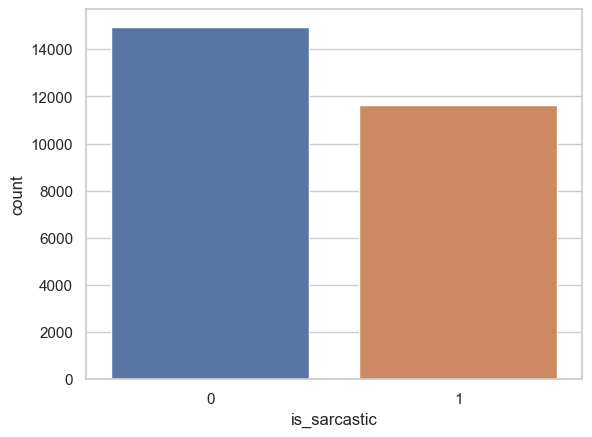

In [45]:
# here I notice that the dependent variable is unbalanced.
# there are arround 4K more samples of non sarcastic headlines
sns.set_theme(style='whitegrid')
ax = sns.countplot(x='is_sarcastic', data=df)

### Transmitter distribution

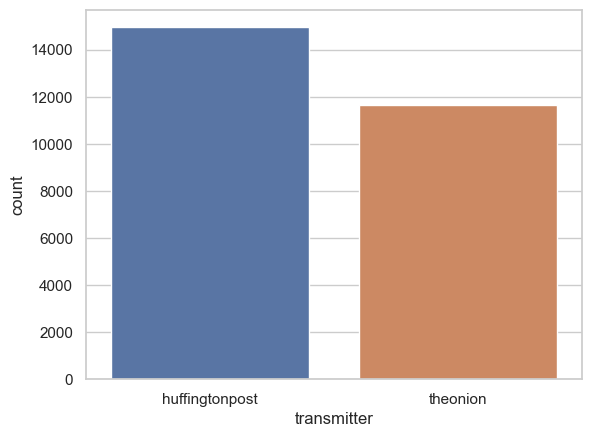

In [46]:
# here I notice that the dependent variable is unbalanced. Not that much yet unbalanced
sns.set_theme(style='whitegrid')
ax = sns.countplot(x='transmitter', data=df)

### Linear correlation between features

I noticed that the countplots from **trasnsmitter distribution** and **sarcastic distribution** are quite similar. I want to know if they are that much related

In [47]:
from pandas import factorize

columns = ['transmitter', 'is_sarcastic']
X = df[columns]
X.loc[:, 'transmitter'] = factorize(X['transmitter'])[0]

It's important to note that a matrix of all ones is a very unlikely scenario in real-world data, as it would indicate that all of the variables are perfectly related and there is no variability or uniqueness in the data. However, with this information I deduce that **theonion** source always throw sarcastic headlines meanwhile **huffingtonpost** always gives non-sarcastic headlines.

In [48]:
# calculate the correlation matrix
corr = X.corr()
corr

,transmitter,is_sarcastic
transmitter,1.0,1.0
is_sarcastic,1.0,1.0


## Feature extraction

In this section I present the way I map from raw text to vectoriezed samples in order to inject the vectorized samples into M.L models

### Denoise headlines

In [49]:
def denoise_text(text: str):
    
    from nltk.tokenize import RegexpTokenizer
    from nltk.corpus import stopwords
    from nltk.stem import PorterStemmer, WordNetLemmatizer
    
    def concat(tokens):
        return ' '.join(tokens)

    # lower case
    text = text.lower()
    
    # remove punctuation
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    
    # remove numbers
    tokens = [token for token in tokens if not token.isnumeric()]
    
    # remove stop words
    stop_words = stopwords.words('english')
    tokens = [token for token in tokens if token not in stop_words]
    
    # stem words
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    # lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return concat(tokens)

In [50]:
df['clean_headline'] = df['headline'].apply(denoise_text)

In [51]:
df[['headline', 'clean_headline']].head(10)

,headline,clean_headline
0,former versace store clerk sues over secret 'b...,former versac store clerk sue secret black cod...
1,the 'roseanne' revival catches up to our thorn...,roseann reviv catch thorni polit mood better wors
2,mom starting to fear son's web series closest ...,mom start fear son web seri closest thing gran...
3,"boehner just wants wife to listen, not come up...",boehner want wife listen come altern debt redu...
4,j.k. rowling wishes snape happy birthday in th...,j k rowl wish snape happi birthday magic way
5,advancing the world's women,advanc world woman
6,the fascinating case for eating lab-grown meat,fascin case eat lab grown meat
7,"this ceo will send your kids to school, if you...",ceo send kid school work compani
8,top snake handler leaves sinking huckabee camp...,top snake handler leav sink huckabe campaign
9,friday's morning email: inside trump's presser...,friday morn email insid trump presser age


### Most commond words in denoised headlines

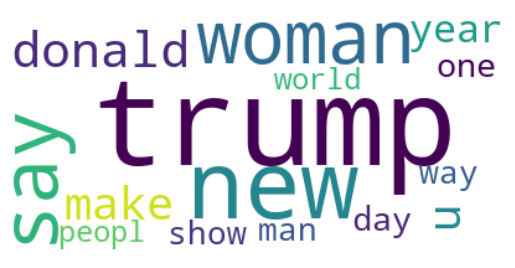

In [52]:
# more frequent words used in not sarcastic headlines
ns_words = ' '.join(df[df['is_sarcastic'] == 0]['clean_headline'])
wc = WordCloud(max_words = 15, collocations = False, background_color = 'white').generate(ns_words)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.show()

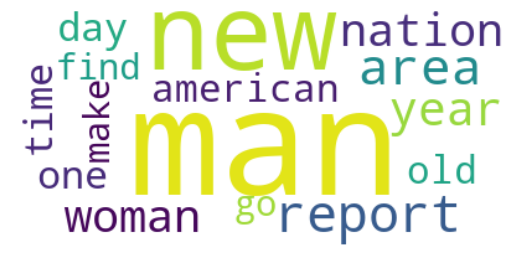

In [53]:
# more frequent words used in sarcastic headlines
ns_words = ' '.join(df[df['is_sarcastic'] == 1]['clean_headline'])
wc = WordCloud(max_words = 15, collocations = False, background_color = 'white').generate(ns_words)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.show()

### Vectorize words

To add context to the machine learning algorithm I use de sets of ngrams of size 1 and 2. This makes increase the size of data but I hope it helps the algoritms to understand the problem.

In [54]:
from sklearn.feature_extraction.text import CountVectorizer

corpus = df['clean_headline']
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1,2))
X = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names_out()

In [55]:
feature_names[100:125]

array(['31st age', '34th', '34th anniversari', '34th season',
       '34th short', '350th', '350th anniversari', '35th',
       '35th anniversari', '35th year', '37th', '37th sailor', '38c',
       '38c episod', '393rd', '393rd guilti', '3d', '3d model',
       '3d print', '3d printer', '3d world', '3m', '3m introduc', '3po',
       '3po red'], dtype=object)

In [56]:
feature_names[100000:100025]

array(['pressur self', 'pressur senat', 'pressur sleep', 'pressur stanc',
       'pressur use', 'pressur wife', 'prestigi', 'prestigi honor',
       'prestigi univers', 'preston', 'preston cook', 'presum',
       'presum innoc', 'presum man', 'presumpt', 'presumpt cruelli',
       'presumpt prepar', 'presumpt republican', 'pretend',
       'pretend care', 'pretend everyth', 'pretend faint',
       'pretend frazzl', 'pretend fuck', 'pretend hear'], dtype=object)

In [57]:
# using less bits to represent data
X = X.astype('int32')
# X.toarray() <- Even decreasing the number of bits to representing the data, it does not work, I have 8gb of ram and it exceeds 14gb
sdf = pd.DataFrame.sparse.from_spmatrix(X)
sdf[['is_sarcastic', 'transmitter']] = df[['is_sarcastic', 'transmitter']]

In [142]:
sdf[list(range(10)) + ['is_sarcastic', 'transmitter']].head()

,0,1,2,3,4,5,6,7,8,9,is_sarcastic,transmitter
0,0,0,0,0,0,0,0,0,0,0,0.0,huffingtonpost
1,0,0,0,0,0,0,0,0,0,0,0.0,huffingtonpost
2,0,0,0,0,0,0,0,0,0,0,1.0,theonion
3,0,0,0,0,0,0,0,0,0,0,1.0,theonion
4,0,0,0,0,0,0,0,0,0,0,0.0,huffingtonpost


## Pipelines

As I want to automate the process of vectorize words, I'll make use of sklearn; Pipelines and ColumnTransformer

In [154]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextDenoiser(BaseEstimator, TransformerMixin):
    
    def __denoise_text(self, text):
        from nltk.tokenize import RegexpTokenizer
        from nltk.corpus import stopwords
        from nltk.stem import PorterStemmer, WordNetLemmatizer
        
        def concat(tokens):
            return ' '.join(tokens)

        # lower case
        text = text.lower()

        # remove punctuation
        tokenizer = RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(text)

        # remove numbers
        tokens = [token for token in tokens if not token.isnumeric()]

        # remove stop words
        stop_words = stopwords.words('english')
        tokens = [token for token in tokens if token not in stop_words]

        # stem words
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(token) for token in tokens]

        # lemmatize words
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

        return concat(tokens)

    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        print('training text denoiser...')
        X = pd.DataFrame(X)
        self.input_features = X.columns
        return self

    def transform(self, X, y=None):
        print('transforming columns in text denoiser...')
        X = pd.DataFrame(X)
        for c in X.columns:
            X[c] = X[c].apply(self.__denoise_text)
        return X

    def get_feature_names_out(self, input_features=None):
        return self.input_features

In [173]:
from sklearn.base import BaseEstimator, TransformerMixin

class TransmitterExtracter(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        print('training transmitter extracter...')
        X = pd.DataFrame(X)
        self.input_features = X.columns
        return self
    
    def __extracter(self, text):
        return text.split('.')[1]

    def transform(self, X, y=None):
        print('transforming transmitter extracter...')
        X = pd.DataFrame(X)
        for c in X.columns:
            X[c] = X[c].apply(self.__extracter)
        return X

    def get_feature_names_out(self, input_features=None):
        return self.input_features

In [189]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OrdinalEncoder

vectorizer_pipeline = Pipeline(steps=[
        ('headline', TextDenoiser()),
        # ('vectorizer', CountVectorizer(analyzer='word', ngram_range=(1,2)))
    ])

transmitter_pipeline = Pipeline(steps=[
        ('extracter', TransmitterExtracter()),
        ('encoder', OrdinalEncoder())
    ])

transformer = ColumnTransformer(transformers=[
            ('vectorizer', vectorizer_pipeline, ['headline']),
            ('transmitter_encoded', transmitter_pipeline, ['article_link'])
        ],
        remainder='passthrough')

pipe = Pipeline([
    ('transformer', transformer)
])

In [190]:
X = pipe.fit_transform(X_a)
pipe

training text denoiser...
transforming columns in text denoiser...
training transmitter extracter...
transforming transmitter extracter...


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vectorizer',
                                                  Pipeline(steps=[('headline',
                                                                   TextDenoiser())]),
                                                  ['headline']),
                                                 ('transmitter_encoded',
                                                  Pipeline(steps=[('extracter',
                                                                   TransmitterExtracter()),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['article_link'])]))])

In [191]:
pipe.get_feature_names_out()

array(['vectorizer__headline', 'transmitter_encoded__article_link',
       'remainder__is_sarcastic'], dtype=object)

In [192]:
pd.DataFrame(X, columns=pipe.get_feature_names_out()).head()

,vectorizer__headline,transmitter_encoded__article_link,remainder__is_sarcastic
0,former versac store clerk sue secret black cod...,0.0,0
1,roseann reviv catch thorni polit mood better wors,0.0,0
2,mom start fear son web seri closest thing gran...,1.0,1
3,boehner want wife listen come altern debt redu...,1.0,1
4,j k rowl wish snape happi birthday magic way,0.0,0


In [193]:
X_a.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0
